In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
words = open('names.txt', 'r').read().splitlines()

In [16]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [17]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [18]:
# dataset

block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
# indexes for 80 and 90% of words
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
# [len(x) for x in [Xtr, Xdev, Xte]]

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [19]:
# MLP
n_embd = 10
n_hidden = 200

emb_matrix = torch.randn((vocab_size, n_embd)) # lookup table


# l1
W1 = torch.randn((n_embd * block_size, n_hidden)) * 0.3 # (5/3 / ((n_embd * block_size)**0.5))
# b1 = torch.randn(n_hidden) * 0.01

# l2
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0

# stuff for BatchNorm layer
batch_norm_gain = torch.ones((1, n_hidden))
batch_norm_bias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

params = [emb_matrix, W1, W2, b2, 
          batch_norm_gain, batch_norm_bias]
for p in params:
    p.requires_grad = True

# assert sum(p.nelement() for p in params) == 11897

In [20]:
max_steps =  20000
batch_size = 32
lossi = []

In [21]:
for i in range(max_steps):
    # mini batch: {batch_size} random indexes (from 0 to len of dataset)
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = emb_matrix[Xb] # emb character indexes -> their vectors
    embcat = emb.view(emb.shape[0], -1) # conc vectors to multiply them by weights
    # print(emb.shape, embcat.shape)
    
    h_preact = embcat @ W1 #  + b1 # hidden l pre-activation
    bnmeani = h_preact.mean(0, keepdim=True)
    bnstdi = h_preact.std(0, keepdim=True)
    # https://chatgpt.com/share/67608dff-4090-800d-93a4-d66b77c03faf
    h_preact_normalized = batch_norm_gain * (h_preact - bnmeani) / bnstdi + batch_norm_bias # "BatchNorm" layer 

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(h_preact_normalized) # "non-linearity", specificaly tahn output range is (−1,1)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # logits -> probabilities via softmax + loss function

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update params according to gradient
    lr = 0.05 if i < max_steps // 2 else 0.01 # step learning rate DECAY
    for p in params:
        p.data += -lr * p.grad

    # stats to print later
    if i % (max_steps // 5) == 0:
        print(f'{i}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.item())

0/20000: 3.3097
4000/20000: 2.2915
8000/20000: 2.6105
12000/20000: 1.9679
16000/20000: 2.3728


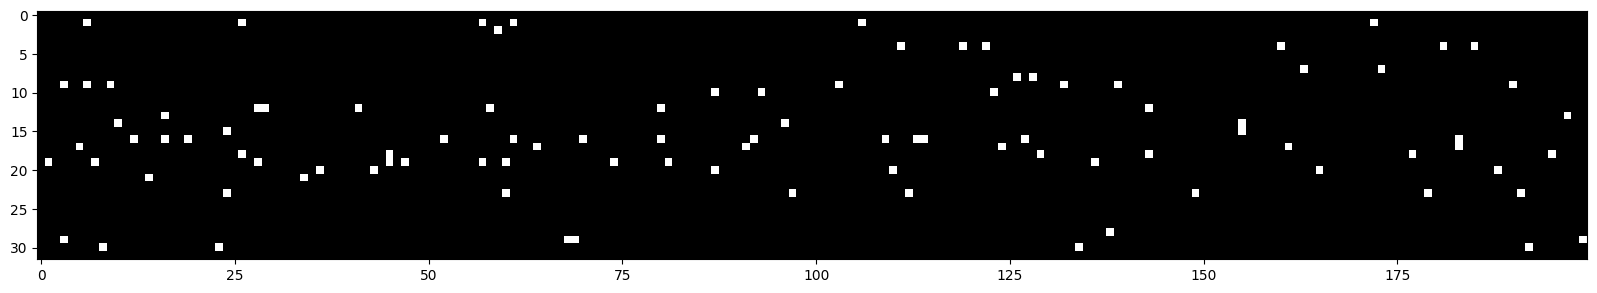

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

In [23]:
# calibration of the batch norm at the end of training
# with torch.no_grad():
#     emb = emb_matrix[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     h_preact = embcat @ W1 + b1
#     #measure the mean/std over the entire training set
#     bnmean = h_preact.mean(0, keepdim=True)
#     bnstd = h_preact.std(0, keepdim=True)

# bnmean, bnmean_running

In [27]:
@torch.no_grad()
def loss_by_split(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = emb_matrix[x]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ W1#+ b1 # hidden l pre-activation
    h_preact_normalized = batch_norm_gain * (h_preact - bnmean_running) / bnstd_running + batch_norm_bias # "BatchNorm" layer 
    # h_preact_normalized = batch_norm_gain * (h_preact - bnmean) / bnstd + batch_norm_bias # "BatchNorm" layer 
    h = torch.tanh(h_preact_normalized) # "non-linearity", specificaly tahn output range is (−1,1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [28]:
loss_by_split('train')
loss_by_split('val')

train 2.2290890216827393
val 2.2373435497283936


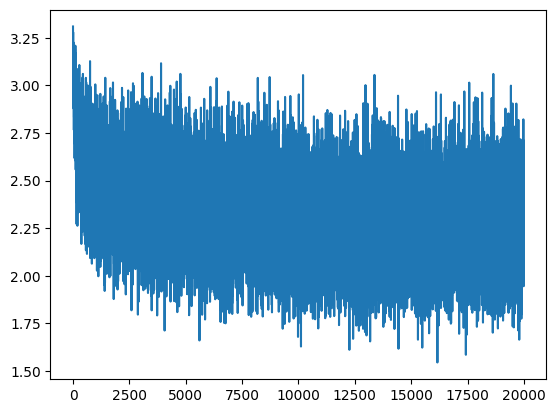

In [29]:
plt.plot(lossi)

In [32]:
# sampling
for _ in range(5):
    out = []

    context = [0] * block_size 
    while True:
        emb = emb_matrix[torch.tensor([context])]
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

nusliwkanalezhvan.
knbelosbavtol.
amllanollandaidhonl.
shatynviksharshowinushatufughvicgluwruvaglanahvinxeshngkondmyunasharlanrovanslevandelizersenrshtbavijaknavfandadejerinzthann.
tandhygharlengstamlareazbindhel.
